In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy
from pyHalo.preset_models import CDM

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [2]:
lens = SampleStrongLens()

In [3]:
pipeline_params = util.hydra_to_dict(config.pipeline)
subhalo_cone = pipeline_params['subhalo_cone']
los_normalization = pipeline_params['los_normalization']
r_tidal = pipeline_params['r_tidal']
sigma_sub = pipeline_params['sigma_sub']
log_mlow = pipeline_params['log_mlow']
log_mhigh = pipeline_params['log_mhigh']

print(f"subhalo_cone: {subhalo_cone}")
print(f"los_normalization: {los_normalization}")
print(f"r_tidal: {r_tidal}")
print(f"sigma_sub: {sigma_sub}")
print(f"log_mlow: {log_mlow}")
print(f"log_mhigh: {log_mhigh}")

subhalo_cone: 10.0
los_normalization: 0.0
r_tidal: 0.5
sigma_sub: 0.055
log_mlow: 6
log_mhigh: 10


In [46]:
log_m_host = np.log10(lens.main_halo_mass)
print(f'log_m_host: {log_m_host}')

kwargs_cosmo = util.get_kwargs_cosmo(lens.cosmo)
pprint(kwargs_cosmo)

# circumvent bug with pyhalo, sometimes fails when redshifts have more than 2 decimal places
z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
print(f'z_lens: {z_lens}, z_source: {z_source}')

log_m_host: 11.854955330626419
{'H0': 67.66, 'Ob0': 0.04897, 'Om0': 0.30966}
z_lens: 0.29, z_source: 0.59


In [5]:
num_realizations = 100

lens_list = []
stats_list = []

for i in tqdm(range(num_realizations)):
    lens_copy = deepcopy(lens)

    realization = CDM(z_lens,
                    z_source,
                    sigma_sub=sigma_sub,
                    log_mlow=log_mlow,
                    log_mhigh=log_mhigh,
                    log_m_host=log_m_host,
                    r_tidal=r_tidal,
                    cone_opening_angle_arcsec=subhalo_cone,
                    LOS_normalization=los_normalization,
                    kwargs_cosmo=kwargs_cosmo)

    # add subhalos
    stats_dict = lens_copy.add_subhalos(realization, return_stats=True)

    lens_list.append(lens_copy)
    stats_list.append(stats_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:51<00:00,  2.32s/it]


In [6]:
pprint(stats_dict)

{'adjusted_einstein_radius': 1.1666098033483692,
 'adjusted_lensing_mass': 430809849932.03827,
 'effective_lensing_mass': 431898205024.59985,
 'original_einstein_radius': 1.168082477232392,
 'percent_change_einstein_radius': 0.12607619005740234,
 'percent_change_lensing_mass': 0.2519934280577977,
 'percent_subhalo_mass_within_einstein_radius': 7.839918079461807,
 'total_mass_subhalos_within_einstein_radius': 1088355092.5615952,
 'total_subhalo_mass': 13882225318.30726}


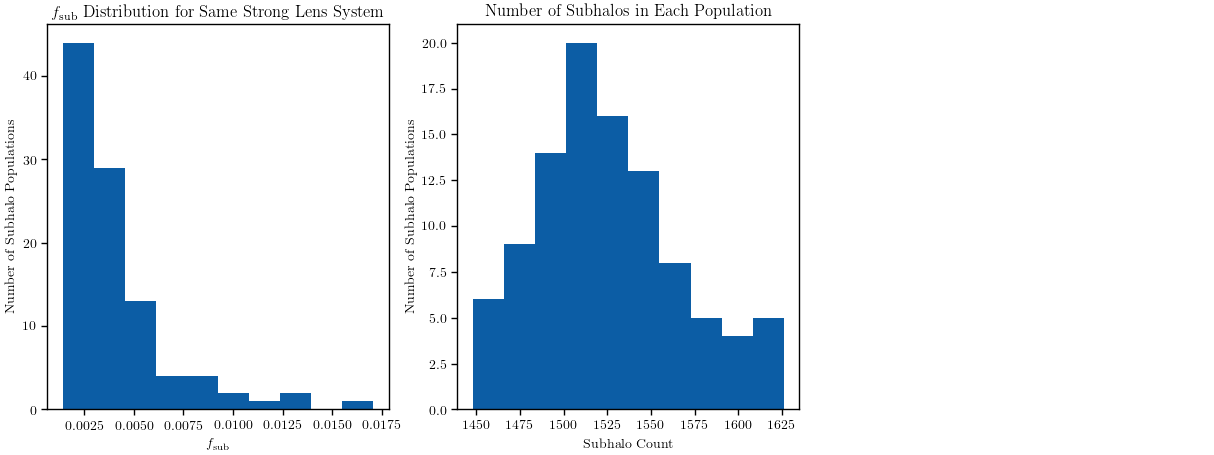

In [32]:
f_sub_list = []

for stats_dict in stats_list:
    effective_lensing_mass = stats_dict['effective_lensing_mass']
    total_mass_subhalos_within_einstein_radius = stats_dict['total_mass_subhalos_within_einstein_radius']
    f_sub = total_mass_subhalos_within_einstein_radius / effective_lensing_mass
    f_sub_list.append(f_sub)

realization_list = [l.realization for l in lens_list]
subhalo_count = [len(r.halos) for r in realization_list]

f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(f_sub_list, bins=int(np.sqrt(num_realizations)))
ax[0].set_xlabel(r'$f_{\rm sub}$')
ax[0].set_ylabel('Number of Subhalo Populations')
ax[0].set_title(r'$f_{\rm sub}$ Distribution for Same Strong Lens System')
ax[1].hist(subhalo_count, bins=int(np.sqrt(num_realizations)))
ax[1].set_xlabel('Subhalo Count')
ax[1].set_ylabel('Number of Subhalo Populations')
ax[1].set_title('Number of Subhalos in Each Population')
ax[2].axis('off')
plt.show()

In [33]:
log_m_host_list = np.linspace(9, 14, 10)
print(log_m_host_list)

num_samples = 10

realization_list = []
for log_m_host in log_m_host_list:
    realization_samples = []
    for i in range(num_samples):
        realization = CDM(z_lens,
                        z_source,
                        sigma_sub=sigma_sub,
                        log_mlow=log_mlow,
                        log_mhigh=log_mhigh,
                        log_m_host=log_m_host,
                        r_tidal=r_tidal,
                        cone_opening_angle_arcsec=subhalo_cone,
                        LOS_normalization=los_normalization,
                        kwargs_cosmo=kwargs_cosmo)
        # print(f'log_m_host: {log_m_host:.2f}, Num halos: {len(realization.halos)}')
        realization_samples.append(realization)
    realization_list.append(realization_samples)

[ 9.          9.55555556 10.11111111 10.66666667 11.22222222 11.77777778
 12.33333333 12.88888889 13.44444444 14.        ]


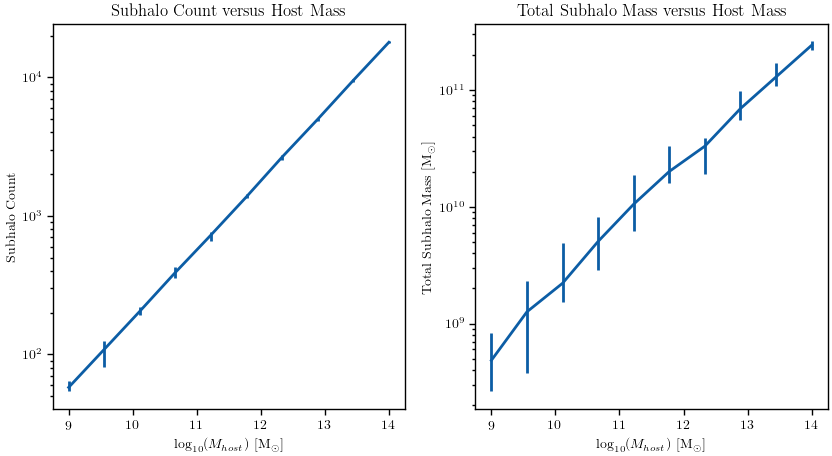

In [40]:
stdev_list, count_list, avg_mass_list = [], [], []
max_list, min_list, mass_max_list, mass_min_list = [], [], [], []
for realization_samples in realization_list:
    counts = [len(r.halos) for r in realization_samples]
    masses = [np.sum([h.mass for h in r.halos]) for r in realization_samples]
    avg_mass = np.mean(masses)
    avg_mass_list.append(avg_mass)
    mass_max_list.append(np.max(masses) - avg_mass)
    mass_min_list.append(avg_mass - np.min(masses))
    avg = np.mean(counts)
    stdev = np.std(counts)
    max_list.append(np.max(counts) - avg)
    min_list.append(avg - np.min(counts))
    count_list.append(avg)
    stdev_list.append(stdev)

count_error = [min_list, max_list]
mass_error = [mass_min_list, mass_max_list]

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].errorbar(log_m_host_list, count_list, yerr=count_error)
ax[0].set_yscale('log')
ax[0].set_ylabel('Subhalo Count')
ax[0].set_xlabel(r'$\log_{10}(M_{host})$ [M$_\odot$]')
ax[0].set_title('Subhalo Count versus Host Mass')
ax[1].errorbar(log_m_host_list, avg_mass_list, yerr=mass_error)
ax[1].set_yscale('log')
ax[1].set_ylabel('Total Subhalo Mass [M$_\odot$]')
ax[1].set_xlabel(r'$\log_{10}(M_{host})$ [M$_\odot$]')
ax[1].set_title('Total Subhalo Mass versus Host Mass')
plt.savefig(os.path.join(figure_dir, 'pyhalo_check_scaling_with_log_host_mass.png'))
plt.show()

In [54]:
z_lens_list = np.linspace(0.01, 1, 10)

log_m_host = np.log10(lens.main_halo_mass)
print(f'log_m_host: {log_m_host}')

num_samples = 10
max_retries = 10

realization_list = []
for z_lens in tqdm(z_lens_list):
    realization_samples = []
    for i in range(num_samples):
        retries = 0
        while True:
            try:
                realization = CDM(z_lens,
                                2.,
                                sigma_sub=sigma_sub,
                                log_mlow=log_mlow,
                                log_mhigh=log_mhigh,
                                log_m_host=log_m_host,
                                r_tidal=r_tidal,
                                cone_opening_angle_arcsec=subhalo_cone,
                                LOS_normalization=los_normalization,
                                kwargs_cosmo=kwargs_cosmo)
            except:
                retries += 1
                if retries < max_retries:
                    break
                continue
            break
        realization_samples.append(realization)
    realization_list.append(realization_samples)

log_m_host: 11.854955330626419


100%|██████████| 10/10 [01:07<00:00,  6.76s/it]


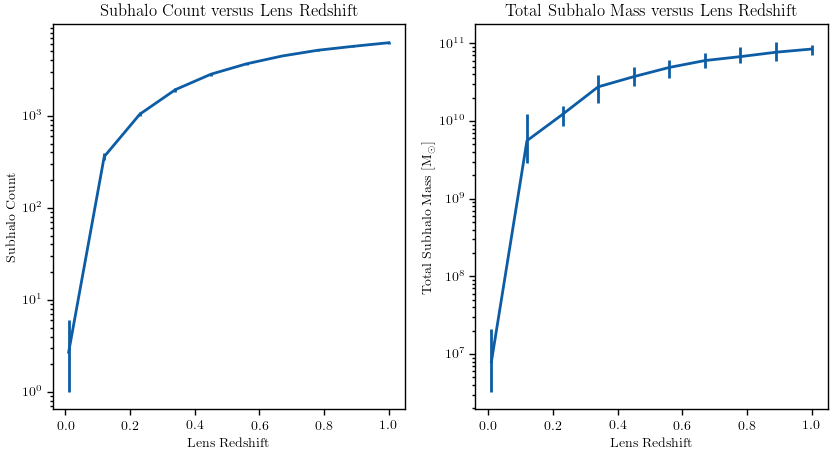

In [58]:
stdev_list, count_list, avg_mass_list = [], [], []
max_list, min_list, mass_max_list, mass_min_list = [], [], [], []
for realization_samples in realization_list:
    counts = [len(r.halos) for r in realization_samples]
    masses = [np.sum([h.mass for h in r.halos]) for r in realization_samples]
    avg_mass = np.mean(masses)
    avg_mass_list.append(avg_mass)
    mass_max_list.append(np.max(masses) - avg_mass)
    mass_min_list.append(avg_mass - np.min(masses))
    avg = np.mean(counts)
    stdev = np.std(counts)
    max_list.append(np.max(counts) - avg)
    min_list.append(avg - np.min(counts))
    count_list.append(avg)
    stdev_list.append(stdev)

count_error = [min_list, max_list]
mass_error = [mass_min_list, mass_max_list]
# pprint(mass_error)

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].errorbar(z_lens_list, count_list, yerr=count_error)
ax[0].set_yscale('log')
ax[0].set_ylabel('Subhalo Count')
ax[0].set_xlabel('Lens Redshift')
ax[0].set_title('Subhalo Count versus Lens Redshift')
ax[1].errorbar(z_lens_list, avg_mass_list, yerr=mass_error)
ax[1].set_yscale('log')
ax[1].set_ylabel('Total Subhalo Mass [M$_\odot$]')
ax[1].set_xlabel('Lens Redshift')
ax[1].set_title('Total Subhalo Mass versus Lens Redshift')
plt.savefig(os.path.join(figure_dir, 'pyhalo_check_scaling_with_lens_redshift.png'))
plt.show()